# DmX Challenge: Predictive Credit Risk Modeling Using Customer Credit Scores and Phone Footprints


In [3]:
# ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────                                                       
# Script Name : training_etl.py
# Author      : Dilan Castañeda                                          
# Created On  : September 18, 2024                                           
# Last Update : September 18, 2024                                         
# Version     : 0.0.1                                          
# Description : Credit risk modeling using bureau reports and phone data to predict client default probability.          
# ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Overview

---
Instituto Tecnológico y de Estudios Superiores de Monterrey

Analítica de datos y herramientas de inteligencia artificial TI3001C.103

Profesor: Enrique Ricardo García Hernández

Equipo 2:
*   Dilan González Castañeda             A00831905
*   Karim Omar Martínez Bazaldúa         A00832999
*   André Ulises Zenteno Ruiz            A00835044
*   Carolina Glorisel Murillo Guajardo   A00834868
---

**Overview**

Credit risk modeling using bureau reports and phone usage data to predict client default probability for loan approval decisions.

**Database Source**

The database for this project was provided by DMX, containing comprehensive credit bureau reports and detailed phone usage data for each client.

**Key Components**

1. Credit Bureau Data:

* Credit history
* Loan inquiries
* Payment behaviors
* Current debt levels


2. Phone Usage Data:

* Subscription type
* Usage patterns
* Payment history
* Device information


3.  Target Variable:

* Client default status (binary: defaulted or not)



**Project Goals**

Develop a predictive model to assess the likelihood of client loan default
Optimize loan approval decisions based on calculated risk
Enhance the overall loan portfolio quality by minimizing potential defaults

**Methodology**

* Utilize machine learning techniques to analyze historical data
* Incorporate both traditional credit metrics and alternative data (phone usage)
* Create a robust model that can handle various data types and complex relationships

**Expected Outcome**
A reliable credit risk assessment tool that can:

* Accurately predict client default probability
* Assist in making informed loan approval decisions
* Potentially increase approval rates for creditworthy clients while minimizing risk

This project aims to leverage the unique combination of traditional credit data and alternative phone usage data provided by DMX to create a more comprehensive and accurate credit risk assessment model.

### 1. ETL for Model Training

#### Purpose:
- Prepare historical data for model development and training.

#### Process:
1. **Extract**: 
   - Pull historical data from DMX database (credit bureau reports and phone usage data).
   - Include all available features and the target variable (default status).

2. **Transform**:
   - Handle missing values, outliers, and data quality issues.
   - Perform feature engineering (e.g., creating interaction terms, deriving new features).
   - Encode categorical variables.
   - Normalize or standardize numerical features.

3. **Load**:
   - Store the processed data in a format suitable for model training (e.g., parquet files, a data warehouse).

#### Benefits:
- Can perform extensive data cleaning and feature engineering.
- Allows for complex transformations that might be computationally expensive.
- Can use the full historical dataset for better feature creation and selection.

By implementing separate ETL processes for training and scoring, we can optimize our credit risk model for both comprehensive learning from historical data and efficient, consistent scoring of new records.

## ETL

### Extract

In [4]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Define the path to the file
# Using the file inside the repository
file_name = r'C:\Users\dilan\Documents\Github\DataAnalysis_and_AI\period_2\Resources\Challenge\base_Reto.csv'
# Using the file from the repository
url = 'https://raw.githubusercontent.com/magotronico/DataAnalysis_and_AI/main/period_2/Resources/Challenge/base_Reto.csv'

# Load original DataBase (csv)
# df = pd.read_csv(file_name, encoding='latin-1') # You can use the file_name variable to load the file if you have it in your local machine
df = pd.read_csv(url, encoding='latin-1')

# Display the first 3 rows of the dataframe
df.head(3)
# Display resume of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25101 entries, 0 to 25100
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Solicitud_id                             25101 non-null  float64
 1   Aprobado                                 25101 non-null  int64  
 2   Hit_Buro_Huella                          25101 non-null  int64  
 3   Malo                                     25101 non-null  int64  
 4   Num_IQ_U3M_PL_Financieras                25101 non-null  int64  
 5   Edad_cliente                             25101 non-null  int64  
 6   Porcentaje_cuentas_abiertas              25101 non-null  float64
 7   Num_IQ_U3M                               25101 non-null  int64  
 8   Num_IQ_U3M_TDC_Banco                     25101 non-null  int64  
 9   MaxMOP_U3M                               25101 non-null  int64  
 10  Saldo_actual_prest_personales            25101

### Transform


#### Estandarize column names

In [6]:
#Create a copy of the original dataframe
df_copy = df.copy(deep=True)
# Estandarize columns names (lowercase and without accents)
df_copy.columns = [unidecode(str(col)).lower() for col in df.columns]
# Replace 'contabilidad' with 'contactabilidad' in column name
df_copy.columns = df_copy.columns.str.replace('contabilidad', 'contactabilidad')

#### Categorize DB based on hit_buro_huella (ScoreCards)

In [7]:
# Split hit_buro_huella into hit_buro and hit_huella
df_copy['hit_buro_huella'] = df_copy['hit_buro_huella'].apply(lambda x: f'{x:02d}')
df_copy['hit_buro'] = df_copy['hit_buro_huella'].str[0].astype(int)
df_copy['hit_huella'] = df_copy['hit_buro_huella'].str[1].astype(int)
df_copy.insert(3, 'hit_buro', df_copy.pop('hit_buro'))
df_copy.insert(4, 'hit_huella', df_copy.pop('hit_huella'))
df_copy.drop('hit_buro_huella', axis=1, inplace=True)

# Grouping info by hit_buro and hit_huella into 4 categories: {1: 00, 2: 01, 3: 10, 4: 11}
df_copy['hit_group'] = df_copy['hit_buro'].astype(str) + df_copy['hit_huella'].astype(str)
df_copy['hit_group'] = df_copy['hit_group'].map({'00': 1, '01': 2, '10': 3, '11': 4})
df_copy.insert(4, 'hit_group', df_copy.pop('hit_group'))

#### Basic Data Exploration on ScoreCards
1. No Credit Score and No Phone Footprint
2. No Credit Score and Phone Footprint
3. Credit Score and No Phone Footprint
4. Credit Score and Phone Footprint

* Check if there are sufficient observations for ScoreCards. For each ScoreCard: 
    * Approval rate (approved by attended)
    * Delinquency rate (bad among observations once approved)
    * Number of observations (of each scorecard with performance and at least 20% with bad outcomes)


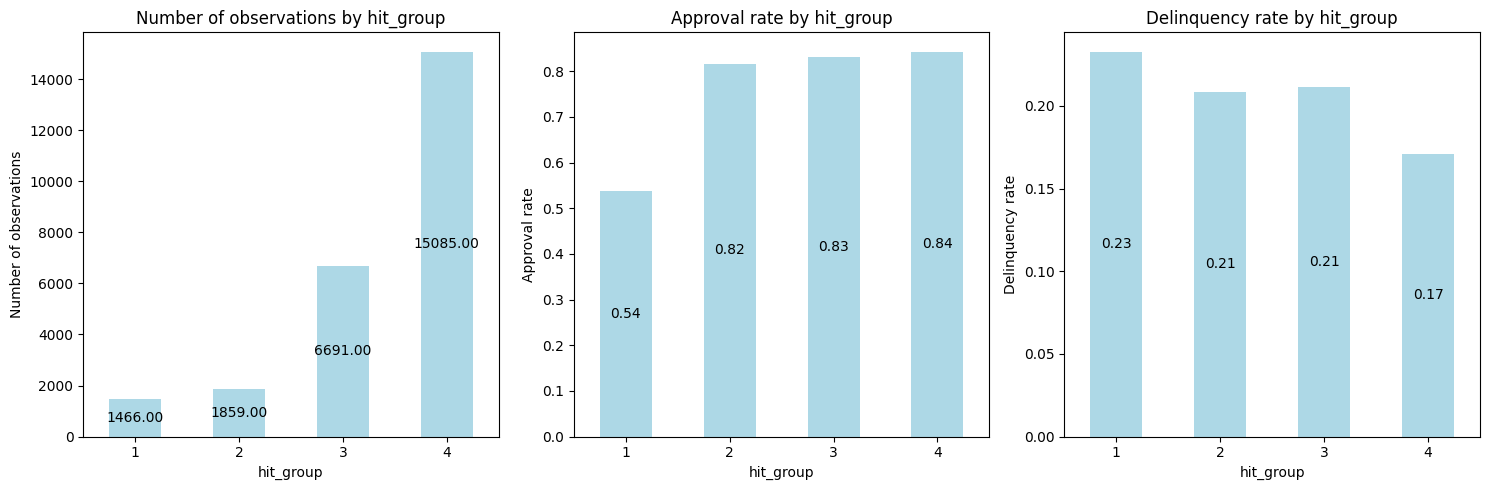

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Number of observations by hit_group 
obs_by_hit_group = df_copy['hit_group'].value_counts().sort_index()

# Approval rate by hit_group
approval_rate_by_hit_group = df_copy.groupby('hit_group')['aprobado'].mean()

# Delinquency rate by hit_group: mean of 'malo' column if 'aprobado' == 1
delinquency_rate_by_hit_group = df_copy[df_copy['aprobado'] == 1].groupby('hit_group')['malo'].mean()

# Plotting the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Number of observations by hit_group
obs_by_hit_group.plot(kind='bar', ax=ax[0], color='lightblue')
ax[0].set_title('Number of observations by hit_group')
ax[0].set_xlabel('hit_group')
ax[0].set_ylabel('Number of observations')

# Approval rate by hit_group
approval_rate_by_hit_group.plot(kind='bar', ax=ax[1], color='lightblue')
ax[1].set_title('Approval rate by hit_group')
ax[1].set_xlabel('hit_group')
ax[1].set_ylabel('Approval rate')

# Delinquency rate by hit_group
delinquency_rate_by_hit_group.plot(kind='bar', ax=ax[2], color='lightblue')
ax[2].set_title('Delinquency rate by hit_group')
ax[2].set_xlabel('hit_group')
ax[2].set_ylabel('Delinquency rate')

for i in range(3):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0)
    for p in ax[i].patches:
        ax[i].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() / 2.), ha='center', va='center', xytext=(0, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

### Load

## Training Models